In [1]:
import argparse
import torch
import torch.nn as nn
import dgl
from dgl.dataloading import MultiLayerFullNeighborSampler, as_edge_prediction_sampler
from dgl.dataloading.negative_sampler import Uniform
import pandas as pd
import numpy as np
import itertools
import tqdm
import dgl.function as fn
import torch
from dgl import save_graphs, load_graphs
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv, HeteroGraphConv
import tqdm
import torch as th
import dgl.nn as dglnn
import gc
import warnings
warnings.filterwarnings('ignore')

gc.collect()

0

In [2]:
parser = argparse.ArgumentParser(description='Link prediction')
parser.add_argument('-f', '--file_path', default='data/graph_data.bin', type=str, help='dgl图文件路径')
parser.add_argument('-d', '--device', default=None, type=str, help='设备, cpu或cuda')
parser.add_argument('-e', '--epoch', default=20, type=int, help='运行回合数')
parser.add_argument('--begin_seed', default=42, type=int, help='起始种子')
parser.add_argument('--end_seed', default=52, type=int, help='结束种子')
args = parser.parse_args()
""
''' gpu训练暂时没跑通
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = device if args.device == None else args.device
'''
hetero_graph = load_graphs('data/model/graph_data.bin')[0][0]

# print(f'device: {device}')
print('图结构: \n', hetero_graph)

图结构: 
 Graph(num_nodes={'customer': 161086, 'product': 2708},
      num_edges={('customer', 'order', 'product'): 11892915, ('product', 'class', 'product'): 1796620, ('product', 'rev_class', 'product'): 1796620, ('product', 'rev_order', 'customer'): 11892915},
      metagraph=[('customer', 'product', 'order'), ('product', 'product', 'class'), ('product', 'product', 'rev_class'), ('product', 'customer', 'rev_order')])


In [3]:
# 假设g是已经构建好的异构图
edges = {}
for etype in hetero_graph.canonical_etypes:
    u, v = hetero_graph.all_edges(etype=etype, order='eid')
    edges[etype] = (u.numpy(), v.numpy())
    print(f'Edge Type: {etype}')
    print(f'Source Node IDs: {u.numpy()[:10]} ...')
    print(f'Destination Node IDs: {v.numpy()[:10]} ...')
    print()

Edge Type: ('customer', 'order', 'product')
Source Node IDs: [81478 81478 81478 81478 81478 81478 81478 81478 81478 81478] ...
Destination Node IDs: [2182 2118 2057 2047 2039 2012  499 1918 1828 1821] ...

Edge Type: ('product', 'class', 'product')
Source Node IDs: [0 0 0 0 0 0 0 0 0 0] ...
Destination Node IDs: [ 1  2  3  4  5  6  7  8  9 10] ...

Edge Type: ('product', 'rev_class', 'product')
Source Node IDs: [0 0 0 0 0 0 0 0 0 0] ...
Destination Node IDs: [ 1  2  3  4  5  6  7  8  9 10] ...

Edge Type: ('product', 'rev_order', 'customer')
Source Node IDs: [2182 2118 2057 2047 2039 2012  499 1918 1828 1821] ...
Destination Node IDs: [81478 81478 81478 81478 81478 81478 81478 81478 81478 81478] ...



In [4]:
class RelGraphConvLayer(nn.Module):

    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 num_bases,
                 *,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop

        # 这个地方只是起到计算的作用, 不保存数据
        self.conv = HeteroGraphConv({
            # graph conv 里面有模型参数weight,如果外边不传进去的话,里面新建
            # 相当于模型加了一层全链接, 对每一种类型的边计算卷积
            rel: GraphConv(in_feat, out_feat, norm='right',
                           weight=False, bias=False)
            for rel in rel_names
        })

        self.use_weight = weight
        self.use_basis = num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = dglnn.WeightBasis(
                    (in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                # 每个关系,又一个weight,全连接层
                self.weight = nn.Parameter(
                    th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(
                    self.weight, gain=nn.init.calculate_gain('relu'))

        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)

        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))

        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):

        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            # 这每个关系对应一个权重矩阵对应输入维度和输出维度
            wdict = {self.rel_names[i]: {'weight': w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}

        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(
                k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs

        # 多类型的边结点卷积完成后的输出
        # 输入的是blocks 和 embeding
        # inputs = {key: value.to(device) for key, value in inputs.items()}
        hs = self.conv(g, inputs, mod_kwargs=wdict)

        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)

        return {ntype: _apply(ntype, h) for ntype, h in hs.items()}


class RelGraphEmbed(nn.Module):
    r"""Embedding layer for featureless heterograph."""

    def __init__(self,
                 g,
                 embed_size,
                 embed_name='embed',
                 activation=None,
                 dropout=0.0):
        super(RelGraphEmbed, self).__init__()
        self.g = g
        self.embed_size = embed_size
        self.embed_name = embed_name
        self.activation = activation
        self.dropout = nn.Dropout(dropout)

        # create weight embeddings for each node for each relation
        self.embeds = nn.ParameterDict()
        for ntype in g.ntypes:
            embed = nn.Parameter(torch.Tensor(
                g.number_of_nodes(ntype), self.embed_size))
            nn.init.xavier_uniform_(embed, gain=nn.init.calculate_gain('relu'))
            self.embeds[ntype] = embed

    def forward(self, block=None):

        return self.embeds


class EntityClassify(nn.Module):
    def __init__(self,
                 g,
                 h_dim, out_dim,
                 num_bases=-1,
                 num_hidden_layers=1,
                 dropout=0,
                 use_self_loop=False):
        super(EntityClassify, self).__init__()
        self.g = g
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.rel_names = list(set(g.etypes))
        self.rel_names.sort()
        if num_bases < 0 or num_bases > len(self.rel_names):
            self.num_bases = len(self.rel_names)
        else:
            self.num_bases = num_bases
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.use_self_loop = use_self_loop

        self.embed_layer = RelGraphEmbed(g, self.h_dim)
        self.layers = nn.ModuleList()
        # i2h
        self.layers.append(RelGraphConvLayer(
            self.h_dim, self.h_dim, self.rel_names,
            self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
            dropout=self.dropout, weight=False))

        # h2h , 这里不添加隐层,只用2层卷积
        # for i in range(self.num_hidden_layers):
        #    self.layers.append(RelGraphConvLayer(
        #        self.h_dim, self.h_dim, self.rel_names,
        #        self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
        #        dropout=self.dropout))
        # h2o

        self.layers.append(RelGraphConvLayer(
            self.h_dim, self.out_dim, self.rel_names,
            self.num_bases, activation=None,
            self_loop=self.use_self_loop))

    # 输入 blocks,embeding
    def forward(self, h=None, blocks=None):
        if h is None:
            # full graph training
            h = self.embed_layer()
        if blocks is None:
            # full graph training
            for layer in self.layers:
                h = layer(self.g, h)
        else:
            # minibatch training
            # 输入 blocks,embeding
            for layer, block in zip(self.layers, blocks):
                h = layer(block, h)
        return h
    
    def inference(self, g, batch_size, device="cpu", num_workers=0, x=None):

        if x is None:
            x = self.embed_layer()

        for l, layer in enumerate(self.layers):
            y = {
                k: th.zeros(
                    g.number_of_nodes(k),
                    self.h_dim if l != len(self.layers) - 1 else self.out_dim)
                for k in g.ntypes
                }
            
            sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1)
            dataloader = dgl.dataloading.DataLoader(
                g,
                {k: th.arange(g.number_of_nodes(k)) for k in g.ntypes},
                sampler,
                batch_size=batch_size,
                shuffle=True,
                drop_last=False,
                num_workers=num_workers)
            
            for input_nodes, output_nodes, blocks in tqdm.tqdm(dataloader):
                # print(input_nodes)
                block = blocks[0]  # .to(device)
                h = {k: x[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
                h = layer(block, h)
                for k in h.keys():
                    y[k][output_nodes[k]] = h[k].cpu()
            x = y
        return y


# 根据节点类型和节点ID抽取embeding 参与模型训练更新
def extract_embed(node_embed, input_nodes):
    emb = {}
    for ntype, nid in input_nodes.items():
        nid = input_nodes[ntype]
        emb[ntype] = node_embed[ntype][nid.to('cpu')]
    return emb

# Define a Heterograph Conv model


class Model(nn.Module):

    def __init__(self, graph, hidden_feat_dim, out_feat_dim):
        super().__init__()
        self.rgcn = EntityClassify(graph,
                                   hidden_feat_dim,
                                   out_feat_dim)
        self.pred = HeteroDotProductPredictor()

    def forward(self, h, pos_g, neg_g, blocks, etype):
        h = self.rgcn(h, blocks)  # h 是客户的维度12的特征矩阵，输出是转换后的嵌入
        return self.pred(pos_g, h, etype), self.pred(neg_g, h, etype)
    
    
class MarginLoss(nn.Module):

    def forward(self, pos_score, neg_score):
        # 求损失的平均值 , view 改变tensor 的形状
        # 1- pos_score + neg_score ,应该是 -pos 符号越大变成越小  +neg_score 越小越好
        return (1 - pos_score + neg_score.view(pos_score.shape[0], -1)).clamp(min=0).mean()


class HeteroDotProductPredictor(nn.Module):

    def forward(self, graph, h, etype):
        # 在计算之外更新h, 保存为全局可用
        # h contains the node representations for each edge type computed from node_clf_hetero.py
        with graph.local_scope():
            graph.ndata['h'] = h  # assigns 'h' of all node types in one shot
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)  # * 在这里给出分数
            return graph.edges[etype].data['score']


def train_etype_one_epoch(etype, spec_dataloader):
    losses = []
    #  input nodes 为采样的subgraph中的所有的节点的集合
    for input_nodes, pos_g, neg_g, blocks in tqdm.tqdm(spec_dataloader):
        emb = extract_embed(all_node_embed, input_nodes)
        pos_score, neg_score = model(emb, pos_g, neg_g, blocks, etype)
        loss = loss_func(pos_score, neg_score)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('{:s} Seed {:d} | avg_Loss {:.4f}'.format(etype, seed, sum(losses) / len(losses)))
    return losses

In [5]:
# 执行训练
loss_table = {}
for seed in range(48, 49):
    torch.manual_seed(seed)
    dgl.seed(seed)
    # 采样定义
    # neg_sample_count = (hetero_graph['order'].num_edges() // hetero_graph.nodes['customer'][0]['index'].shape[0]) * 1000
    neg_sample_count = 15
    batch_size = hetero_graph['order'].num_edges() // 250
    # 采样2层全部节点
    sampler = MultiLayerFullNeighborSampler(2)
    # 边的条数,数目比顶点个数多很多.
    # 这是 EdgeDataLoader 数据加载器

    hetero_graph.edges['order'].data['train_mask'] = torch.zeros(hetero_graph['order'].num_edges(), dtype=torch.bool).bernoulli(1.0)
    train_item_eids = hetero_graph.edges['order'].data['train_mask'].nonzero(as_tuple=True)[0]

    sampler = as_edge_prediction_sampler(sampler, negative_sampler=dgl.dataloading.negative_sampler.Uniform(neg_sample_count))

    item_dataloader = dgl.dataloading.DataLoader(
        hetero_graph, {'order': train_item_eids}, sampler,
        batch_size=batch_size, shuffle=True)

    hidden_feat_dim = 12  # 客户特征长度
    out_feat_dim = 12

    embed_layer = RelGraphEmbed(hetero_graph, hidden_feat_dim)
    all_node_embed = embed_layer()

    model = Model(hetero_graph, hidden_feat_dim, out_feat_dim)
    # 优化模型所有参数, 主要是weight以及输入的embeding参数
    all_params = itertools.chain(model.parameters(), embed_layer.parameters())
    optimizer = torch.optim.Adam(all_params, lr=0.01, weight_decay=0)

    loss_func = MarginLoss()
    
    print("start seed:", seed)
    model.train()
    losses = train_etype_one_epoch('order', item_dataloader)
    loss_table[seed] = losses
    # 保存模型
    torch.save(model.state_dict(), f'ckpt/test/model_params_{seed}.pt')
    torch.save(embed_layer, f'ckpt/test/model_embed_layer_{seed}.pt')
    
# 保存训练结果
loss_table = pd.DataFrame(loss_table)
loss_table.to_csv(f'data/test/result.csv', index=False, encoding='utf-8-sig')

start seed: 48


100%|██████████| 251/251 [05:59<00:00,  1.43s/it]


order Seed 48 | avg_Loss 0.3856


<Axes: >

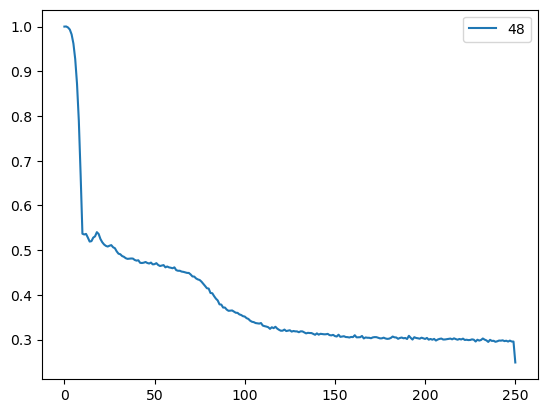

In [6]:
loss_table.plot()

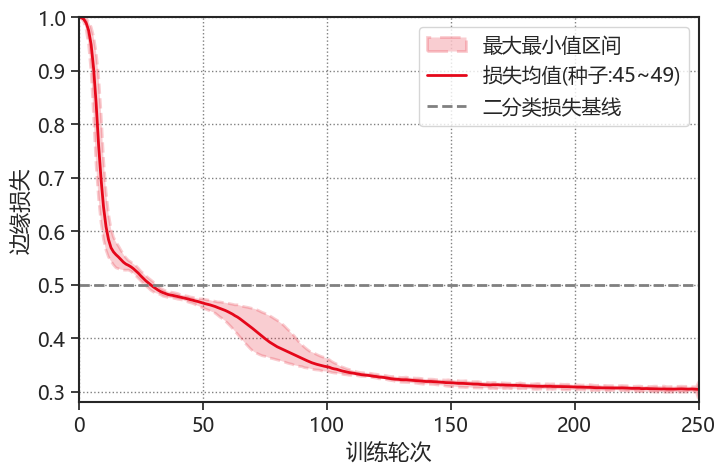

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

def smooth(data: pd.Series):
    smooth_data = data.ewm(alpha=0.3).mean()
    return smooth_data

file_path = 'data/result/result_multi.csv'

plt.figure(figsize=(8, 5))
ax = sns.set_theme(style='ticks', font_scale=1.3)
plt.rcParams['font.family'] = 'Microsoft Yahei'
plt.grid(ls=':', color='grey', lw=1)
plt.xlabel('训练轮次')
plt.ylabel('边缘损失')
plt.ylim((0.28, 1))
plt.xlim((0, 250))
tmp = pd.read_csv(file_path)
y = tmp['mean']
min_y = tmp['min']
max_y = tmp['max']
x = range(len(y))
plt.fill_between(x, smooth(min_y), smooth(max_y), alpha=0.2, color='#e5071a', label='最大最小值区间', linestyle='--', lw=2)
ax = sns.lineplot(x=x, y=smooth(y), label='损失均值(种子:45~49)', c='#e5071a', lw=2)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.legend(loc=1)
plt.savefig('image/train_loss.pdf', bbox_inches='tight')

In [50]:
torch.save(model, f'data/model/model_seed_48.pt')

In [24]:
model.load_state_dict(torch.load('ckpt/model_params_45.pt'))

<All keys matched successfully>

给定参数

In [7]:
embed_layer = torch.load(f'ckpt/test/model_embed_layer_48.pt')
all_node_embed = embed_layer()

model = Model(hetero_graph, hidden_feat_dim, out_feat_dim)
model.load_state_dict(torch.load('ckpt/test/model_params_48.pt'))

<All keys matched successfully>

推断嵌入向量

In [8]:
# 模型预估的结果, 最后应该使用 inference, 这里得到的是logit
with torch.no_grad():
    inference_out = model.rgcn.inference(hetero_graph, batch_size, 'cpu', 0, all_node_embed)
print('商品嵌入矩阵大小: ', inference_out["product"].shape)
print('客户嵌入矩阵大小: ', inference_out["customer"].shape)
print(inference_out['customer'][0])
print(inference_out['product'][0])
torch.save(inference_out, 'data/result/embedding.pt')

100%|██████████| 4/4 [00:00<00:00,  9.37it/s]

商品嵌入矩阵大小:  torch.Size([2708, 12])
客户嵌入矩阵大小:  torch.Size([161086, 12])
tensor([-0.9068, -2.2004, -0.7731, -1.7059,  1.3683,  1.1030,  1.5802, -1.5604,
        -0.6413,  2.7755, -0.8019,  2.2613])
tensor([ 0.5371,  0.8826,  0.7209,  1.1758, -0.4478, -1.3561, -1.0212,  0.4532,
         1.2797, -0.4117,  0.2468, -0.6435])


In [9]:
predict = (inference_out["customer"] @ inference_out["product"].T).detach().numpy()  # 购买意愿值

In [46]:
torch.save(predict, 'data/model/buy_prob.pt')  # 保存购买概率
predict = torch.load('data/model/buy_prob.pt').detach().numpy()

In [10]:
predict

array([[-13.037918 , -12.795927 , -12.978089 , ..., -15.396273 ,
        -15.049432 , -15.150128 ],
       [-12.508056 , -12.27808  , -12.4522915, ..., -15.617071 ,
        -15.28643  , -15.385057 ],
       [-13.158329 , -12.916099 , -13.098502 , ..., -15.849941 ,
        -15.499831 , -15.602184 ],
       ...,
       [-12.665194 , -12.432641 , -12.608743 , ..., -15.410814 ,
        -15.078482 , -15.17728  ],
       [-12.549961 , -12.32477  , -12.496649 , ..., -16.744295 ,
        -16.416494 , -16.518236 ],
       [-13.092585 , -12.849399 , -13.03169  , ..., -16.246214 ,
        -15.888512 , -15.992089 ]], dtype=float32)

In [11]:
sort_target = np.sort(predict, axis=1)

In [12]:
sort_target

array([[-23.743584, -23.671196, -22.0054  , ...,  -9.166466,  -9.132278,
         -9.041115],
       [-23.506123, -23.461258, -21.874096, ...,  -9.871876,  -9.852   ,
         -9.840105],
       [-24.270077, -24.148378, -22.52338 , ...,  -9.659321,  -9.637966,
         -9.503305],
       ...,
       [-23.33724 , -23.32597 , -21.692078, ...,  -9.720033,  -9.713648,
         -9.597228],
       [-24.469261, -24.405994, -22.890709, ..., -11.203552, -11.167712,
        -11.10943 ],
       [-24.913414, -24.64789 , -23.125473, ...,  -9.613761,  -9.503406,
         -9.350552]], dtype=float32)

In [15]:
target = predict.argmax(axis=1)

In [16]:
pd.Series(target).value_counts()

256     56361
858     40250
1059    35348
178     18207
388      3842
723      2975
886      2446
1830      689
2046      342
1329      271
1373      148
35        125
2600       36
554        33
2634        9
356         4
Name: count, dtype: int64